# Strojové učenie

# Zdroje
[Encoding] - https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931

[Stromy] - http://scikit-learn.org/stable/modules/tree.html

# Knižnice

In [98]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

import pydotplus
import collections

In [8]:
from sklearn.preprocessing import LabelEncoder

In [150]:
#Normalizujeme si kategoricke atributy na cisla
def encodeByNum(data):
    category_data = data.select_dtypes('object')
    lb_make = LabelEncoder()
    
    category_data = category_data.apply(lb_make.fit_transform)
    return category_data

In [151]:
def init_dataset(file):
    # Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
    data = pd.read_csv(file, sep='\t', index_col=0)
    
    metadata = data.drop(['DATE_OF_BIRTH', 'CLASS'], axis=1)
    col_names = metadata.select_dtypes('object').columns
    metadata.loc[:, col_names] = encodeByNum(metadata)
    metadata['CLASS'] = data['CLASS']
    
    print(metadata.info())
    return metadata

# Dataset

In [158]:
#Inicializacia datasetu so zjednotenými nazvami
test_file = "data/zadanie4/ctest.csv"
test_data = init_dataset(test_file)
test_X = test_data.drop('CLASS', axis=1)
test_y = test_data['CLASS']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 0 to 971
Data columns (total 39 columns):
AGE                          972 non-null float64
SEX                          972 non-null float64
ON_THYROXINE                 972 non-null bool
QUERY_ON_THYROXINE           972 non-null bool
ON_ANTITHYROID_MEDICATION    972 non-null bool
SICK                         972 non-null bool
PREGNANT                     972 non-null bool
THYROID_SURGERY              972 non-null bool
I131_TREATMENT               972 non-null bool
QUERY_HYPOTHYROID            972 non-null bool
QUERY_HYPERTHYROID           972 non-null bool
LITHIUM                      972 non-null bool
GOITRE                       972 non-null bool
TUMOR                        972 non-null bool
HYPOPITUITARY                972 non-null bool
PSYCH                        972 non-null bool
TSH_MEASURED                 972 non-null bool
TSH                          972 non-null float64
T3_MEASURED                  972 non-nul

In [159]:
#Inicializacia datasetu so zjednotenými nazvami
train_file = "data/zadanie4/ctrain.csv"
train_data = init_dataset(train_file)
train_X = train_data.drop('CLASS', axis=1)#.loc[0:984]
train_y = train_data['CLASS']#.loc[0:984]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2798 entries, 0 to 2799
Data columns (total 39 columns):
AGE                          2798 non-null float64
SEX                          2798 non-null float64
ON_THYROXINE                 2798 non-null bool
QUERY_ON_THYROXINE           2798 non-null bool
ON_ANTITHYROID_MEDICATION    2798 non-null bool
SICK                         2798 non-null bool
PREGNANT                     2798 non-null bool
THYROID_SURGERY              2798 non-null bool
I131_TREATMENT               2798 non-null bool
QUERY_HYPOTHYROID            2798 non-null bool
QUERY_HYPERTHYROID           2798 non-null bool
LITHIUM                      2798 non-null bool
GOITRE                       2798 non-null bool
TUMOR                        2798 non-null bool
HYPOPITUITARY                2798 non-null bool
PSYCH                        2798 non-null bool
TSH_MEASURED                 2798 non-null bool
TSH                          2798 non-null float64
T3_MEASURED         

# Rozhodovací strom algoritmom CART 

In [160]:
from sklearn import tree

In [161]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_X, train_y)

In [162]:
y_pred = clf.predict(test_X)

In [164]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(test_y, y_pred))  
print(classification_report(test_y, y_pred))

[[933   1   1   0]
 [  0  10   1   0]
 [  1   4   4   0]
 [  1   0   0  16]]
                     precision    recall  f1-score   support

           NEGATIVE       1.00      1.00      1.00       935
    OVERREPLACEMENT       0.67      0.91      0.77        11
REPLACEMENT_THERAPY       0.67      0.44      0.53         9
   UNDERREPLACEMENT       1.00      0.94      0.97        17

        avg / total       0.99      0.99      0.99       972



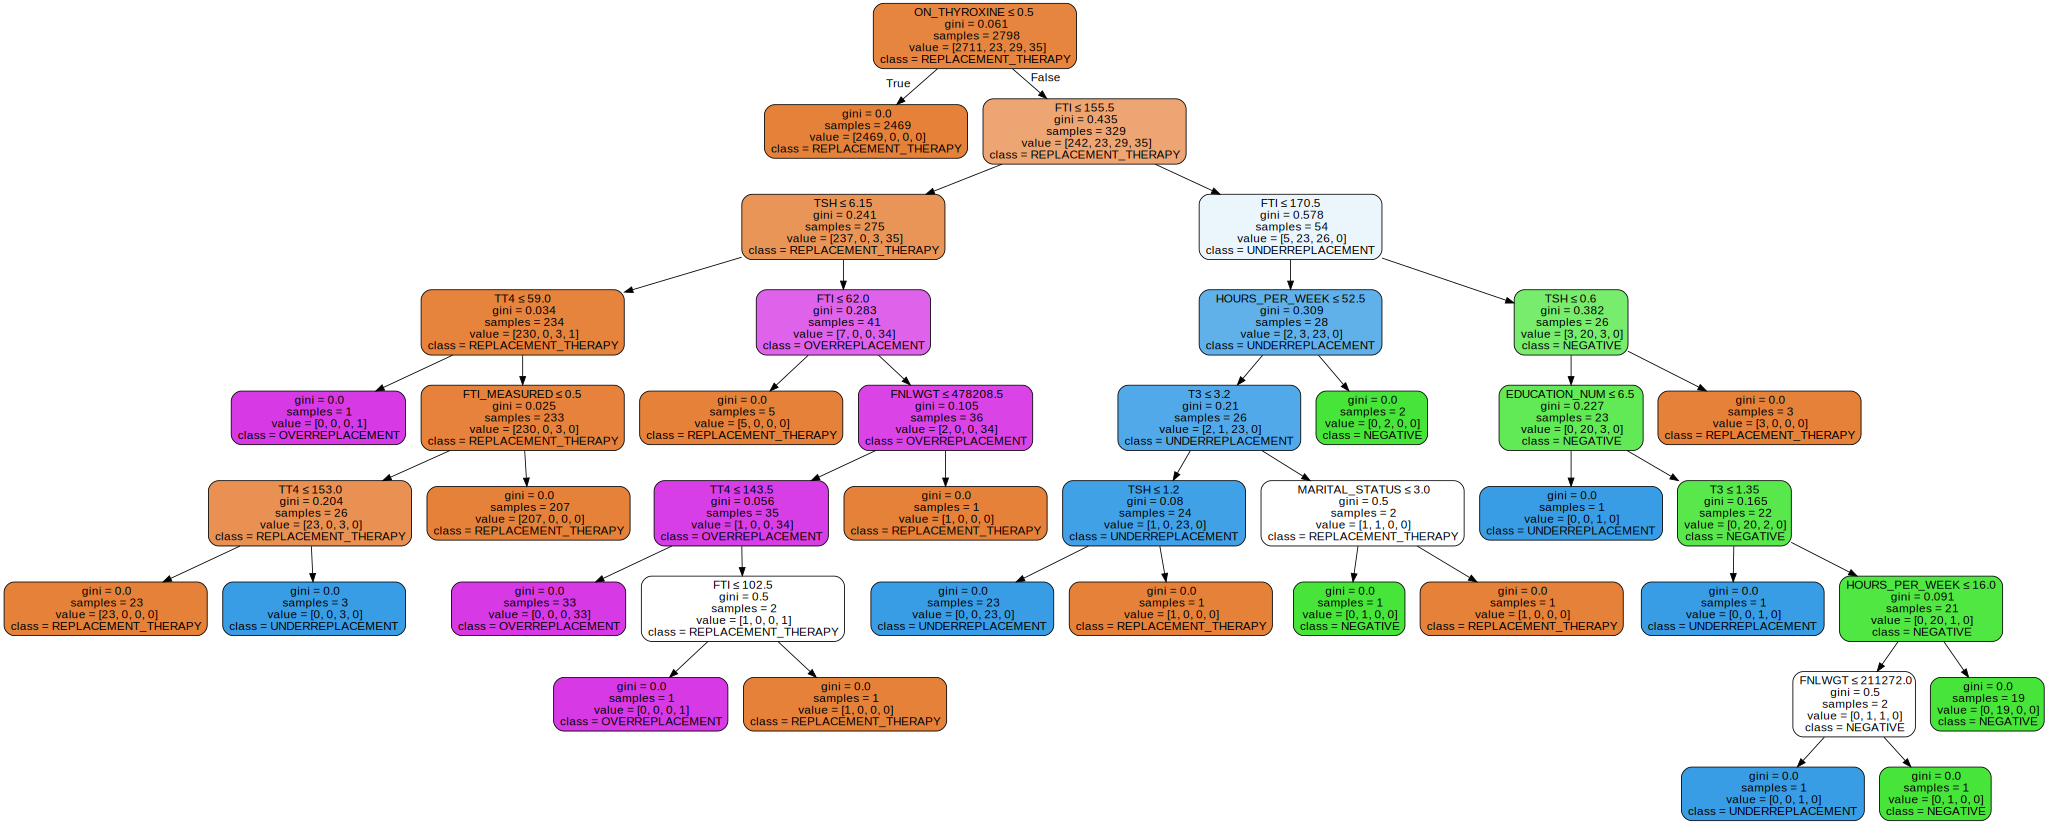

In [165]:
# Visualize data
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=train_X.columns,  
                         class_names=train_y.unique(),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("img/tree") 
graph